<style>
    .markdown-body {
        max-width: 1150px;
        margin: auto;
        text-align: justify;
        border: 1px solid #ddd;
        padding: 40px;
        border-radius: 4px;
    }
</style>

<div class="markdown-body">

# Asset Allocation Exercise

In this exercise, we will go through the following steps:

1. **Load Aswath Damodaran’s data:** We will use historical return data on stocks, bonds, and bills from the United States available at [Aswath Damodaran's website](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datacurrent.html).

2. **Get risky asset excess returns for stocks and bonds:** We will calculate excess returns for stocks and bonds over the risk-free rate (3-month T.Bill).

3. **Calculate the MVP and MSRP using Python Optimization Package:** We will use the `scipy.optimize` package to calculate the Minimum Variance Portfolio (MVP) and the Maximum Sharpe Ratio Portfolio (MSRP). Note that there are various Python optimization packages available. You can explore other professional packages for Operation Research at [Python for Operations Research](https://wiki.python.org/moin/PythonForOperationsResearch).

4. **Get the risky asset frontier with different weights on MVP:** Finally, we will visualize the risky asset frontier by plotting the relationship between the weights on the MVP and the resulting portfolio risk and return.

</div>

In [34]:
# !pip install --upgrade openpyxl
# !pip install --upgrade xlrd

In [33]:
# Below we import the necessary libraries/modules to run the code. You might find that you need to install some of them.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# Load data
file = "histretSP.xls"
df = pd.read_excel(file, sheet_name='Returns by year', header=19)

# df.head()

# Customize date range
start_date = 1928
end_date = 2023 #2022 or 2023?

# Drop NaN values
df = df.dropna()

In [35]:
# Now we just convert the year column to integers to be able to play with the span we'd like to analyze
df['Year'] = df['Year'].astype(int)

df = df[(df['Year'] >= start_date) & (df['Year'] <= end_date)]

# Compute excess returns
df['ExRet_Stocks'] = df['S&P 500 (includes dividends)'] - df['3-month T.Bill']
df['ExRet_Bonds'] = df['US T. Bond (10-year)'] - df['3-month T.Bill']

# Calculate mean and covariance of excess returns
excess_ret = df[['ExRet_Stocks', 'ExRet_Bonds']].mean().to_numpy()
var_excess = df[['ExRet_Stocks', 'ExRet_Bonds']].cov().to_numpy()

# Objective functions
def min_var(x):
    return x.T @ var_excess @ x

def max_srp(x):
    return -(x @ excess_ret) / np.sqrt(x.T @ var_excess @ x)

# Constraints
initial_guess = np.array([0.5, 0.5])
linear_constraint = LinearConstraint([[1, 1]], [1], [1])

# Calculate MVP and MSRP
result_mvp = minimize(min_var, initial_guess, constraints=linear_constraint)
result_msrp = minimize(max_srp, initial_guess, constraints=linear_constraint)

# Calculate weights and returns for different combinations of MVP and MSRP
w_1 = np.arange(-1, 2, 0.01)
w_2 = 1 - w_1
w_mvp, w_msrp = result_mvp.x, result_msrp.x
w_combinations = np.outer(w_1, w_mvp) + np.outer(w_2, w_msrp)

# Calculate risk and return for the combinations
rp_excess = w_combinations @ excess_ret
vol_excess = np.sqrt([w @ var_excess @ w.T for w in w_combinations])

## 1. 2-Risky-Asset Portfolio Case

### a. Edit the efficient frontier graph in sample code. Add x and y axis labels, show individual risky assets, MVP and MSRP on the graph (each should be a point on the graph). 

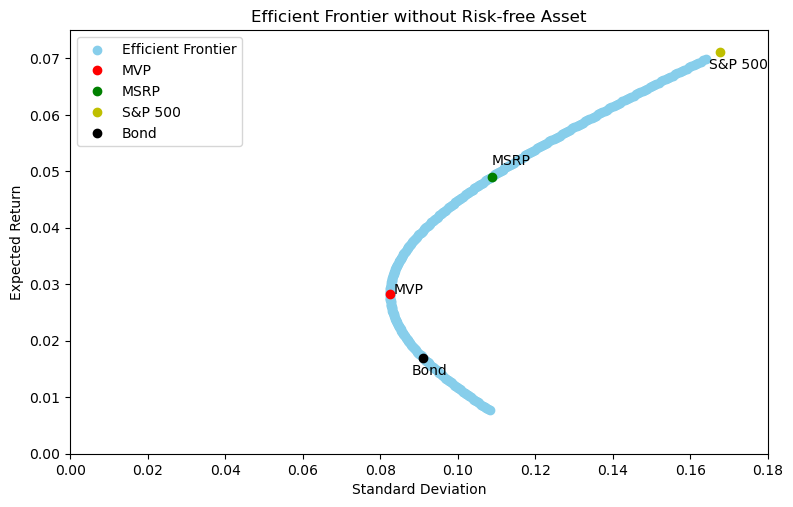

In [120]:
# Calculate standard deviations and expected returns for individual assets
stock_vol = df['ExRet_Stocks'].std()
bond_vol = df['ExRet_Bonds'].std()
stock_ret = df['ExRet_Stocks'].mean()
bond_ret = df['ExRet_Bonds'].mean()

# Set plot size
plt.figure(figsize=(9,5.5))
plt.xlim(0, 0.18)
plt.ylim(0, 0.075)

# Plot the efficient frontier, points of interest, and the Capital Market Line
plt.scatter(vol_excess, rp_excess, color = 'skyblue')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier without Risk-free Asset')

# Add MVP to the plot
plt.plot(np.sqrt(result_mvp.fun), w_mvp @ excess_ret, 'ro')
plt.annotate('MVP', (np.sqrt(result_mvp.fun) + 0.001, w_mvp @ excess_ret))

# Add MSRP to the plot
plt.plot(np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret, 'go')
plt.annotate('MSRP', (np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret + 0.002))

# Add individual risky assets to the plot
plt.plot(stock_vol, stock_ret, 'yo')
plt.annotate('S&P 500', (stock_vol - 0.003, stock_ret - 0.003))
plt.plot(bond_vol, bond_ret, 'ko')
plt.annotate('Bond', (bond_vol - 0.003, bond_ret - 0.003))

plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond'])
plt.show()


### b. Add a riskless asset, which by definition has mean and standard deviation equal to zero, to the two risky-asset case. Plot the new efficient frontier on the efficient frontier from (a). Make sure you have a nice legend. 

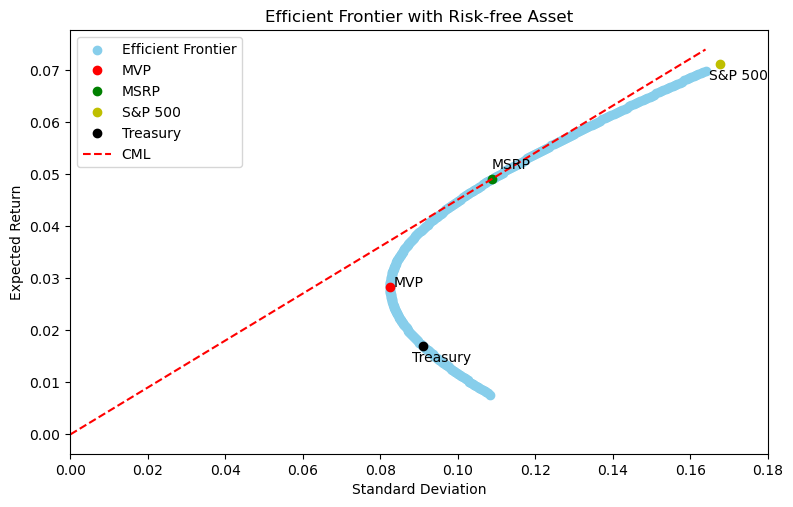

In [113]:
# Assume the risk-free rate is the mean of the '3-month T.Bill' column
risk_free_rate = df['3-month T.Bill'].mean() - df['3-month T.Bill'].mean()
# Given that the risk_free_rate = 0, the y-axis label could be Expected Returns for the following questions.

# Calculate Sharpe ratio for the MSRP
msrp_sharpe_ratio = (w_msrp @ excess_ret) / np.sqrt(w_msrp @ var_excess @ w_msrp.T)

# Define the range for the capital market line
cml_x = np.linspace(0, max(vol_excess), 100)  # Standard deviation from 0 to max(vol_excess)
cml_y = risk_free_rate + msrp_sharpe_ratio * cml_x  # Expected return based on the Sharpe ratio

# Set plot size
plt.figure(figsize=(9,5.5))
plt.xlim(0, 0.18)

# Plot the efficient frontier, points of interest, and the Capital Market Line
plt.scatter(vol_excess, rp_excess, color = 'skyblue')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Risk-free Asset')

# Add MVP to the plot
plt.plot(np.sqrt(result_mvp.fun), w_mvp @ excess_ret, 'ro')
plt.annotate('MVP', (np.sqrt(result_mvp.fun) + 0.001, w_mvp @ excess_ret))

# Add MSRP to the plot
plt.plot(np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret, 'go')
plt.annotate('MSRP', (np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret + 0.002))

# Add individual risky assets to the plot
plt.plot(stock_vol, stock_ret, 'yo')
plt.annotate('S&P 500', (stock_vol - 0.003, stock_ret - 0.003))
plt.plot(bond_vol, bond_ret, 'ko')
plt.annotate('Bond', (bond_vol - 0.003, bond_ret - 0.003))

# Plot the Capital Market Line
plt.plot(cml_x, cml_y, 'r--', label='CML')

plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond',
            'CML'])
plt.show()


### c. Find an efficient portfolio on the new efficient frontier (two risky assets + a riskless asset) that has a standard deviation level larger than the standard deviation of MSRP and requires leverage in the amount of 25%, i.e., 125% invested in MSRP and -25% in the risk-free asset. What is the expected return and standard deviation of this portfolio and what are the weights in stock, bond, and risk-free asset?  Call this portfolio L (for levered and label it on your graph).

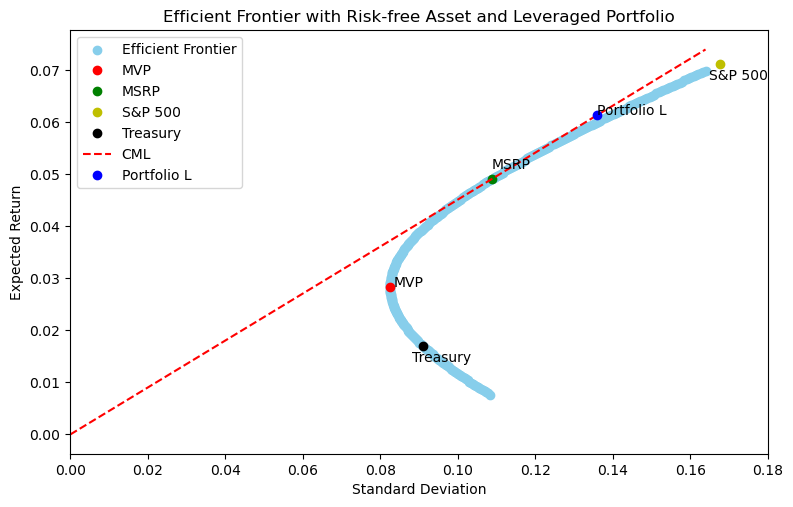

In [112]:
# Calculate MSRP's expected return and standard deviation
msrp_ret = w_msrp @ excess_ret
msrp_std = np.sqrt(w_msrp @ var_excess @ w_msrp.T)

# Leverage calculations for portfolio 'L': 125% invested in MSRP, -25% in risk-free asset
leverage_ratio = 1.25
L_weights = w_msrp * leverage_ratio
L_ret = leverage_ratio * msrp_ret
L_std = leverage_ratio * msrp_std

# Set plot size
plt.figure(figsize=(9,5.5))
plt.xlim(0, 0.18)

# Plot the efficient frontier, points of interest, and the Capital Market Line
plt.scatter(vol_excess, rp_excess, color = 'skyblue')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Risk-free Asset and Leveraged Portfolio')

# Add MVP to the plot
plt.plot(np.sqrt(result_mvp.fun), w_mvp @ excess_ret, 'ro')
plt.annotate('MVP', (np.sqrt(result_mvp.fun) + 0.001, w_mvp @ excess_ret))

# Add MSRP to the plot
plt.plot(np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret, 'go')
plt.annotate('MSRP', (np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret + 0.002))

# Add individual risky assets to the plot
plt.plot(stock_vol, stock_ret, 'yo')
plt.annotate('S&P 500', (stock_vol - 0.003, stock_ret - 0.003))
plt.plot(bond_vol, bond_ret, 'ko')
plt.annotate('Bond', (bond_vol - 0.003, bond_ret - 0.003))

# Plot the Capital Market Line
plt.plot(cml_x, cml_y, 'r--', label='CML')

# Add the Leveraged Portfolio 'L' to the plot
plt.plot(L_std, L_ret, 'bo')
plt.annotate('Portfolio L', (L_std, L_ret))

plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond',
            'CML','Portfolio L'])
plt.show()


### d. Find the highest-return portfolio you can with the same or very similar standard deviation as portfolio L, but that does not use the riskless asset, i.e., uses risky assets only.  Call this portfolio U for unlevered because it does not use leverage.  Plot this on the same axes as portfolio L.  What are the allocations to stock, bond, and risk-free asset for portfolio U?  Make a little table that summarizes for portfolios L and U the portfolio weights, mean returns, standard deviations, and Sharpe ratios and comment. 

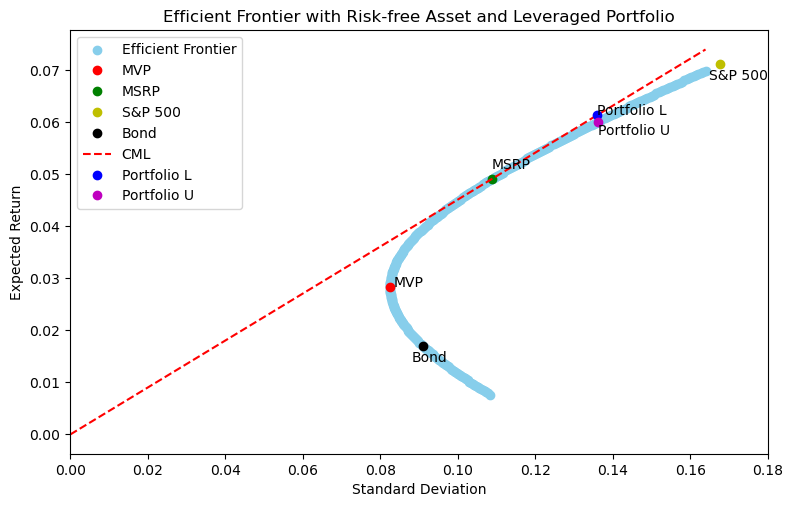

In [116]:
# Find the portfolio 'U' with standard deviation close to 'L' but without leverage
# We'll search among the combinations of risky assets along the efficient frontier
min_diff_idx = np.argmin(np.abs(vol_excess - L_std))
U_ret = rp_excess[min_diff_idx]
U_std = vol_excess[min_diff_idx]
U_weights = w_combinations[min_diff_idx]

# Set plot size
plt.figure(figsize=(9,5.5))
plt.xlim(0, 0.18)

# Plot the efficient frontier, points of interest, and the Capital Market Line
plt.scatter(vol_excess, rp_excess, color = 'skyblue')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Risk-free Asset and Leveraged Portfolio')

# Add MVP to the plot
plt.plot(np.sqrt(result_mvp.fun), w_mvp @ excess_ret, 'ro')
plt.annotate('MVP', (np.sqrt(result_mvp.fun) + 0.001, w_mvp @ excess_ret))

# Add MSRP to the plot
plt.plot(np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret, 'go')
plt.annotate('MSRP', (np.sqrt(w_msrp @ var_excess @ w_msrp.T), w_msrp @ excess_ret + 0.002))

# Add individual risky assets to the plot
plt.plot(stock_vol, stock_ret, 'yo')
plt.annotate('S&P 500', (stock_vol - 0.003, stock_ret - 0.003))
plt.plot(bond_vol, bond_ret, 'ko')
plt.annotate('Bond', (bond_vol - 0.003, bond_ret - 0.003))

# Plot the Capital Market Line
plt.plot(cml_x, cml_y, 'r--', label='CML')

# Add the Leveraged Portfolio 'L' to the plot
plt.plot(L_std, L_ret, 'bo')
plt.annotate('Portfolio L', (L_std, L_ret))

# Add portfolio 'U' to the plot
plt.plot(U_std, U_ret, 'mo', label='Portfolio U')
plt.annotate('Portfolio U', (U_std, U_ret - 0.0025))

plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond',
            'CML','Portfolio L','Portfolio U'])
plt.show()

In [182]:
# Calculate Sharpe ratios for portfolios L and U
# Since risk free rate = 0, we can use return as excess return
L_sharpe_ratio = L_ret / L_std
U_sharpe_ratio = U_ret / U_std

# Summarize the information in a table
summary_table = pd.DataFrame({
    'Portfolio': ['L (Levered)', 'U (Unlevered)'],
    'Stock Weight': [L_weights[0], U_weights[0]],
    'Bond Weight': [L_weights[1], U_weights[1]],
    'Risk-Free Weight': [(1 - leverage_ratio), 0], 
    'Mean Return': [L_ret, U_ret],
    'Standard Deviation': [L_std, U_std],
    'Sharpe Ratio': [L_sharpe_ratio, U_sharpe_ratio]
})

summary_table

,Portfolio,Stock Weight,Bond Weight,Risk-Free Weight,Mean Return,Standard Deviation,Sharpe Ratio
0,L (Levered),0.740723,0.509277,-0.25,0.061340,0.135956,0.451171
1,U (Unlevered),0.795748,0.204252,0.00,0.060098,0.136215,0.441201


## 2. 3-Risky-Asset Portfolio Case

### a. Edit the efficient frontier graph in sample code. Add x and y axis labels, show individual risky assets, MVP and MSRP on the graph (each should be a point on the graph). 

In [122]:
# Treasury bill return 
riskless_asset = pd.read_excel(file, sheet_name='T. Bill rates', header=10)

# Compute excess returns
df['ExRet_Stocks'] = df['S&P 500 (includes dividends)'] - df['3-month T.Bill']
df['ExRet_Bonds'] = df['US T. Bond (10-year)'] - df['3-month T.Bill']
df['ExRet_Housing'] = df['Real Estate'] - df['3-month T.Bill']

excess_ret = df[['ExRet_Stocks', 'ExRet_Bonds', 'ExRet_Housing']].mean().to_numpy()
var_excess = df[['ExRet_Stocks', 'ExRet_Bonds', 'ExRet_Housing']].cov().to_numpy()

# Updated constraints (now for three assets)
num_assets = 3  # Now we have three assets
initial_guess = np.array([1./num_assets] * num_assets)
linear_constraint = LinearConstraint(np.ones(num_assets), [1], [1])

# Calculate MVP and MSRP with the new settings
result_mvp = minimize(min_var, initial_guess, method='SLSQP', bounds=[(0,1)] * num_assets, constraints=linear_constraint)
result_msrp = minimize(max_srp, initial_guess, method='SLSQP', bounds=[(0,1)] * num_assets, constraints=linear_constraint)

# Extracting weights for MVP and MSRP
weights_mvp = result_mvp.x
weights_msrp = result_msrp.x

In [129]:
# Calculate returns and volatilities for MVP and MSRP
return_mvp = np.dot(weights_mvp, excess_ret)
volatility_mvp = np.sqrt(weights_mvp.T @ var_excess @ weights_mvp)
sharpe_ratio_mvp = return_mvp / volatility_mvp

return_msrp = np.dot(weights_msrp, excess_ret)
volatility_msrp = np.sqrt(weights_msrp.T @ var_excess @ weights_msrp)
sharpe_ratio_msrp = return_msrp / volatility_msrp

# Create a table to report the results
results_table = pd.DataFrame({
    'Portfolio': ['MVP', 'MSRP'],
    'Weights': [weights_mvp, weights_msrp],
    'Return': [return_mvp, return_msrp],
    'Volatility': [volatility_mvp, volatility_msrp],
    'Sharpe Ratio': [sharpe_ratio_mvp, sharpe_ratio_msrp]
})

# Plotting the efficient frontier using two-fund separation
w_1 = np.arange(-1, 2, 0.01)       

w_combinations = np.array([w_1[i] * weights_mvp + (1 - w_1[i]) * weights_msrp for i in range(len(w_1))])

# Calculate risk and return for the combinations
rp_excess = np.dot(w_combinations, excess_ret)
vol_excess = np.sqrt([np.dot(w.T, np.dot(var_excess, w)) for w in w_combinations])

# Calculate individual asset risks and excess returns for plotting
risk_stock = np.sqrt(df['ExRet_Stocks'].var())
return_stock = df['ExRet_Stocks'].mean()
risk_bonds = np.sqrt(df['ExRet_Bonds'].var())
return_bonds = df['ExRet_Bonds'].mean()
risk_housing = np.sqrt(df['ExRet_Housing'].var())
return_housing = df['ExRet_Housing'].mean()


In [134]:
results_table['Weights'] = results_table['Weights'].apply(lambda x: [round(i, 3) for i in x])
round(results_table, 3)

,Portfolio,Weights,Return,Volatility,Sharpe Ratio
0,MVP,"[0.012, 0.315, 0.673]",0.010,0.045,0.231
1,MSRP,"[0.453, 0.346, 0.201]",0.039,0.086,0.455


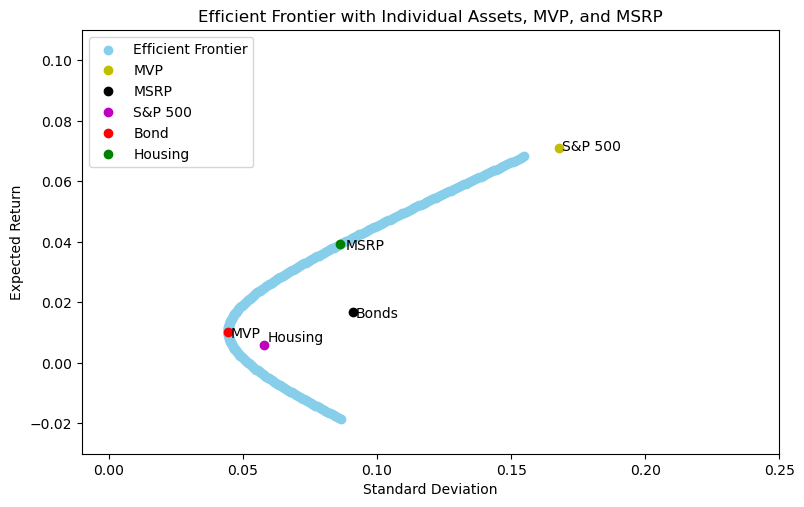

In [155]:
# Set up the plot for the efficient frontier and individual assets
plt.figure(figsize=[9, 5.5])
plt.xlim(-0.01, 0.25)
plt.ylim(-0.03, 0.11)

plt.scatter(vol_excess, rp_excess, label='Efficient Frontier', color='skyblue')  
plt.xlabel('Standard Deviation')  
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Individual Assets, MVP, and MSRP')

# Plot individual risky assets with annotations
plt.plot(risk_stock, return_stock, 'yo')  # Updated marker for Stocks
plt.annotate('S&P 500', (risk_stock+0.001, return_stock-0.001))

plt.plot(risk_bonds, return_bonds, 'ko')  # Bonds
plt.annotate('Bonds', (risk_bonds+0.001, return_bonds-0.002))

plt.plot(risk_housing, return_housing, 'mo')  # Housing
plt.annotate('Housing', (risk_housing+0.001, return_housing+0.001))

# Plot MVP with annotation
plt.plot(volatility_mvp, return_mvp, 'ro')  # MVP point
plt.annotate('MVP', (volatility_mvp+0.001, return_mvp-0.002))  # MVP label

# Plot MSRP with annotation
plt.plot(volatility_msrp, return_msrp, 'go')  # MSRP point
plt.annotate('MSRP', (volatility_msrp+0.002, return_msrp-0.002))  # MSRP label

# Add a legend to clarify the markers
plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond','Housing'],
           loc = 'upper left')

# Display the plot
plt.show()

### b. Calculate the portfolio weights of an efficient portfolio with a fixed level of mean return of 10% using constrained optimization, and no risk-free asset.  (See the code comments for how to add a constraint in optimization.) Plot this point on the same axes as the graph from a) to show that two-fund separation works.

In [144]:
# Sample data for expected_returns and var_excess; replace these with your actual data
expected_returns = df[['ExRet_Stocks', 'ExRet_Bonds', 'ExRet_Housing']].mean().values # Your expected returns for each asset
var_excess = df[['ExRet_Stocks', 'ExRet_Bonds', 'ExRet_Housing']].cov().to_numpy()   # Your covariance matrix of the asset returns

# Rewrite constriants
num_assets = 3
# Target return
target_return = 0.10  # 10%
# Constraint for the portfolio to have a specific return
return_constraint = {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}
# Sum of weights equals 1
sum_weights_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
# Combine constraints
constraints = [return_constraint, sum_weights_constraint]

# Initial guess (evenly distributed weights as starting point)
initial_guess = np.array([1. / num_assets] * num_assets)

# Perform the optimization to minimize variance with the fixed return
result_fixed_return = minimize(
    min_var, 
    initial_guess, 
    method='SLSQP',  
    constraints=constraints,
    options={'maxiter': 10000, 'ftol': 1e-06, 'disp': True}
)

# Check for success and extract the optimal weights
if result_fixed_return.success:
    weights_fixed_return = result_fixed_return.x
    optimized_return = np.dot(weights_fixed_return, expected_returns)
    optimized_volatility = np.sqrt(weights_fixed_return.T @ var_excess @ weights_fixed_return)
else:
    print(f"Optimization failed: {result_fixed_return.message}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0547344899333787
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 6


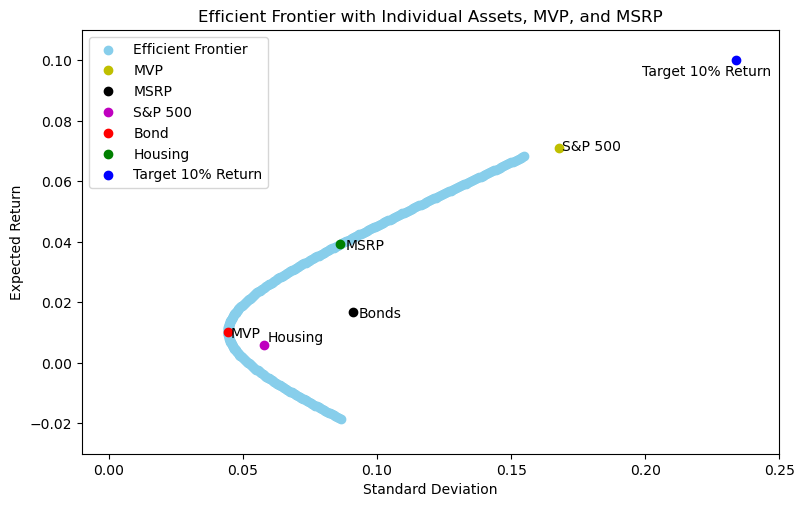

In [153]:
# Calculate the portfolio statistics for the new fixed-return portfolio
fixed_return_portfolio_return = np.dot(weights_fixed_return, expected_returns)
fixed_return_portfolio_volatility = np.sqrt(weights_fixed_return.T @ var_excess @ weights_fixed_return)

# Set up the plot for the efficient frontier and individual assets
plt.figure(figsize=[9, 5.5])
plt.xlim(-0.01, 0.25)
plt.ylim(-0.03, 0.11)

plt.scatter(vol_excess, rp_excess, label='Efficient Frontier', color='skyblue')  
plt.xlabel('Standard Deviation')  
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Individual Assets, MVP, and MSRP')

# Plot individual risky assets with annotations
plt.plot(risk_stock, return_stock, 'yo')  # Updated marker for Stocks
plt.annotate('S&P 500', (risk_stock+0.001, return_stock-0.001))

plt.plot(risk_bonds, return_bonds, 'ko')  # Bonds
plt.annotate('Bonds', (risk_bonds+0.002, return_bonds-0.002))

plt.plot(risk_housing, return_housing, 'mo')  # Housing
plt.annotate('Housing', (risk_housing+0.001, return_housing+0.001))

# Plot MVP with annotation
plt.plot(volatility_mvp, return_mvp, 'ro')  # MVP point
plt.annotate('MVP', (volatility_mvp+0.001, return_mvp-0.002))  # MVP label

# Plot MSRP with annotation
plt.plot(volatility_msrp, return_msrp, 'go')  # MSRP point
plt.annotate('MSRP', (volatility_msrp+0.002, return_msrp-0.002))  # MSRP label

# Plot Target 10% Return with annotation
plt.plot(fixed_return_portfolio_volatility, fixed_return_portfolio_return, 'bo')  # Fixed Return
plt.annotate('Target 10% Return', (fixed_return_portfolio_volatility-0.035, fixed_return_portfolio_return-0.005))

# Add a legend to clarify the markers
plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond','Housing',
            'Target 10% Return'])

# Display the plot
plt.show()


In [187]:
print("Fixed Return Portfolio Expected Return:", fixed_return_portfolio_return)

weight_table = pd.DataFrame({
    'Asset': ['Stock', 'Bonds', 'Housing'],
    'Weights': weights_fixed_return,
    'Return': expected_returns
})
weight_table

Fixed Return Portfolio Expected Return: 0.10000000017219851


,Asset,Weights,Return
0,Stock,1.374382,0.071184
1,Bonds,0.411974,0.016911
2,Housing,-0.786356,0.006105


### c. Add a riskless asset and add the new efficient frontier to the efficient frontier graph from (b). Make sure you have a nice legend.

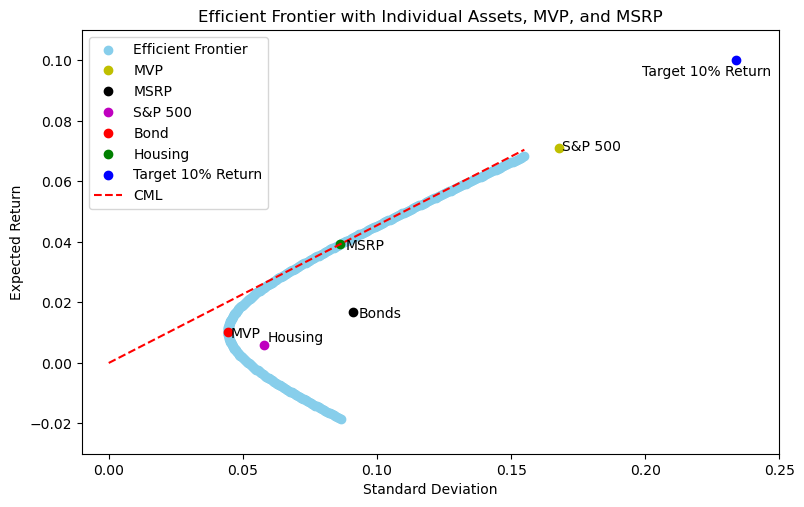

In [156]:
# Calculate the Sharpe ratio for the MSRP
# Since risk free rate is zero, we can simplified our calculation as below:
sharpe_ratio_msrp = return_msrp / volatility_msrp

# Calculate the Capital Market Line (CML)
cml_x = np.linspace(0, max(vol_excess), 100)
cml_y = risk_free_rate + sharpe_ratio_msrp * cml_x

# Set up the plot for the efficient frontier and individual assets
plt.figure(figsize=[9, 5.5])
plt.xlim(-0.01, 0.25)
plt.ylim(-0.03, 0.11)

plt.scatter(vol_excess, rp_excess, label='Efficient Frontier', color='skyblue')  
plt.xlabel('Standard Deviation')  
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Individual Assets, MVP, and MSRP')

# Plot individual risky assets with annotations
plt.plot(risk_stock, return_stock, 'yo')  # Updated marker for Stocks
plt.annotate('S&P 500', (risk_stock+0.001, return_stock-0.001))

plt.plot(risk_bonds, return_bonds, 'ko')  # Bonds
plt.annotate('Bonds', (risk_bonds+0.002, return_bonds-0.002))

plt.plot(risk_housing, return_housing, 'mo')  # Housing
plt.annotate('Housing', (risk_housing+0.001, return_housing+0.001))

# Plot MVP with annotation
plt.plot(volatility_mvp, return_mvp, 'ro')  # MVP point
plt.annotate('MVP', (volatility_mvp+0.001, return_mvp-0.002))  # MVP label

# Plot MSRP with annotation
plt.plot(volatility_msrp, return_msrp, 'go')  # MSRP point
plt.annotate('MSRP', (volatility_msrp+0.002, return_msrp-0.002))  # MSRP label

# Plot Target 10% Return with annotation
plt.plot(fixed_return_portfolio_volatility, fixed_return_portfolio_return, 'bo')  # Fixed Return
plt.annotate('Target 10% Return', (fixed_return_portfolio_volatility-0.035, fixed_return_portfolio_return-0.005))

# Plot Capital Market Line
plt.plot(cml_x, cml_y, 'r--', label='CML')  # CML

# Add a legend to clarify the markers
plt.legend(['Efficient Frontier', 'MVP', 'MSRP','S&P 500','Bond','Housing',
            'Target 10% Return', 'CML'])

# Display the plot
plt.show()


### d. Make a *separate* figure that shows how the efficient frontier changes going from the three-risky-asset to the two-risky-asset case.  To do this, show the risky-asset-only efficient frontiers in both cases on the same set of axes.  Also show either the MSRPs and/or the efficient frontiers with riskless asset on the same axes.  Describe what happens to the frontiers when we go from two to three assets. 

In [158]:
# Calculate the MVP and MSRP for the two-assets case
excess_ret_2_assets = df[['ExRet_Stocks', 'ExRet_Bonds']].mean().to_numpy()
var_excess_2_assets = df[['ExRet_Stocks', 'ExRet_Bonds']].cov().to_numpy()

# Adjusted objective functions for MVP and MSRP (two-assets case)
def min_var_2_assets(weights):
    return weights.T @ var_excess_2_assets @ weights

def max_srp_2_assets(weights):
    return -(weights @ excess_ret_2_assets) / np.sqrt(weights.T @ var_excess_2_assets @ weights)

# Updated constraints (now for two assets)
num_assets_2 = 2
initial_guess_2 = np.array([1./num_assets_2] * num_assets_2)
linear_constraint_2 = LinearConstraint(np.ones(num_assets_2), [1], [1])

# Calculate MVP and MSRP with the new settings (two-assets case)
result_mvp_2_assets = minimize(min_var_2_assets, initial_guess_2, method='SLSQP', bounds=[(0,1)] * num_assets_2, constraints=linear_constraint_2)
result_msrp_2_assets = minimize(max_srp_2_assets, initial_guess_2, method='SLSQP', bounds=[(0,1)] * num_assets_2, constraints=linear_constraint_2)

weights_mvp_2_assets = result_mvp_2_assets.x
weights_msrp_2_assets = result_msrp_2_assets.x

# Calculate returns and volatilities for MVP and MSRP (two-assets case)
return_mvp_2_assets = np.dot(weights_mvp_2_assets, excess_ret_2_assets)
volatility_mvp_2_assets = np.sqrt(weights_mvp_2_assets.T @ var_excess_2_assets @ weights_mvp_2_assets)
return_msrp_2_assets = np.dot(weights_msrp_2_assets, excess_ret_2_assets)
volatility_msrp_2_assets = np.sqrt(weights_msrp_2_assets.T @ var_excess_2_assets @ weights_msrp_2_assets)

excess_ret_2_assets = df[['ExRet_Stocks', 'ExRet_Bonds']].mean().to_numpy()
var_excess_2_assets = df[['ExRet_Stocks', 'ExRet_Bonds']].cov().to_numpy()

slope_2_assets = (return_msrp_2_assets - risk_free_rate) / volatility_msrp_2_assets
cml_x_2_assets = np.linspace(0, volatility_msrp_2_assets, 100)
cml_y_2_assets = risk_free_rate + slope_2_assets * cml_x_2_assets

# Calculate the efficient frontier for the two-assets case
w_combinations_2_assets = np.array([w_1[i] * weights_mvp_2_assets + (1 - w_1[i]) * weights_msrp_2_assets for i in range(len(w_1))])
rp_excess_2_assets = np.dot(w_combinations_2_assets, excess_ret_2_assets)
vol_excess_2_assets = np.sqrt([np.dot(w.T, np.dot(var_excess_2_assets, w)) for w in w_combinations_2_assets])


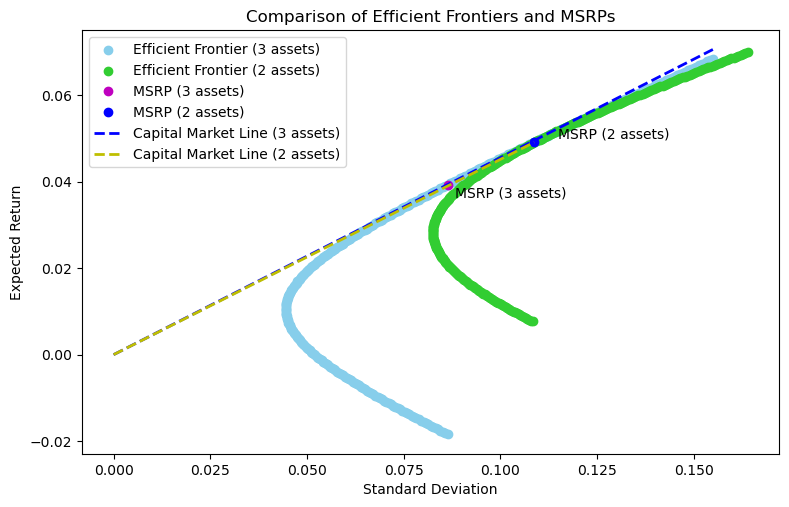

In [181]:
# Set up the plot including both efficient frontiers and MSRPs
plt.figure(figsize=[9, 5.5])

# Labeling Axes and Title
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Comparison of Efficient Frontiers and MSRPs')

# Plotting the efficient frontiers with edge colors only
plt.scatter(vol_excess, rp_excess, label='Efficient Frontier (3 assets)', color='skyblue')  # Efficient frontier for 3 assets
plt.scatter(vol_excess_2_assets, rp_excess_2_assets, label='Efficient Frontier (2 assets)', color='limegreen')  # Efficient frontier for 2 assets

# Plotting the MSRP points
plt.plot(volatility_msrp, return_msrp, 'mo')  # MSRP for 3 assets
plt.plot(volatility_msrp_2_assets, return_msrp_2_assets, 'bo')  # MSRP for 2 assets

# Plotting the CML
plt.plot(cml_x, cml_y, 'b--', label='Capital Market Line (3 assets)', linewidth=2)  # CML for 3 assets
plt.plot(cml_x_2_assets, cml_y_2_assets, 'y--', label='Capital Market Line (2 assets)', linewidth=2)  # CML for 2 assets

# Adding annotations for each element
plt.annotate('MSRP (3 assets)', (volatility_msrp+0.002, return_msrp-0.003))
plt.annotate('MSRP (2 assets)', (volatility_msrp_2_assets+0.006, return_msrp_2_assets+0.001))

# Legend
plt.legend(['Efficient Frontier (3 assets)', 'Efficient Frontier (2 assets)', 
            'MSRP (3 assets)','MSRP (2 assets)',
            'Capital Market Line (3 assets)','Capital Market Line (2 assets)'])

# Show plot
plt.show()
